In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from pingouin import partial_corr
import pingouin as pg
from sklearn.model_selection import RepeatedKFold, cross_val_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

import geopandas as gpd
from geopandas.tools import sjoin

In [33]:
from shapely.geometry import Polygon, box


In [2]:
dfEAus = pd.read_csv('../model_data/dataset_Australia_East_coast_nostrat.csv')

/home/marda/anaconda3/envs/cgrasp/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
dfEAus = dfEAus[['latitude', 'longitude', 'd50',
        'beach_slope_average', 'mstr', 
        'hs_max', 'hs_mean', 'dir', 'tp']].copy()

In [7]:
slopes_dc = gpd.read_file('/media/marda/TWOTB1/USGS/SOFTWARE/Projects/NOPP/global_slope_dc.geojson')

In [8]:
slopes_dc["geometry"] = slopes_dc["geometry"].to_crs(epsg=4326)

In [12]:
slopes_dc = slopes_dc.rename(columns={"Longitude": "longitude", "Latitude": "latitude"})

In [9]:
dfEAus = gpd.GeoDataFrame(
    dfEAus, geometry=gpd.points_from_xy(dfEAus.longitude, dfEAus.latitude))

In [10]:
dfEAus.head()

,latitude,longitude,d50,beach_slope_average,mstr,hs_max,hs_mean,dir,tp,geometry
0,-25.854332,153.078347,0.29525,0.060145,2.068996,4.754424,1.565813,112.555036,8.719285,POINT (153.07835 -25.85433)
1,-25.932753,153.134103,0.29525,0.082709,2.068996,4.754424,1.565813,112.555036,8.719285,POINT (153.13410 -25.93275)
2,-26.008686,153.153149,0.27168,0.060027,2.058574,4.754424,1.565813,112.555036,8.719285,POINT (153.15315 -26.00869)
3,-26.157750,153.097286,0.27168,0.054012,2.050147,4.754424,1.565813,112.555036,8.719285,POINT (153.09729 -26.15775)
4,-26.311676,153.068419,0.27168,0.049932,2.045488,4.754424,1.565813,112.555036,8.719285,POINT (153.06842 -26.31168)


In [13]:
slopes_dc.head()

,longitude,latitude,dc,slope,error_code,geometry
0,-26.3728,-58.4052,20.485961,0.011182,6,POINT (-26.37280 -58.40520)
1,-26.3890,-58.4079,20.485961,0.011312,6,POINT (-26.38900 -58.40790)
2,-26.4057,-58.4098,20.485961,0.010914,6,POINT (-26.40570 -58.40980)
3,-26.4227,-58.4112,20.485961,0.010500,6,POINT (-26.42270 -58.41120)
4,-26.4396,-58.4123,20.485961,3.269054,0,POINT (-26.43960 -58.41230)


In [15]:
len(dfEAus)

256

In [16]:
merged_data = gpd.sjoin_nearest(dfEAus, slopes_dc,distance_col="distances")

/tmp/ipykernel_41459/1652534034.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  merged_data = gpd.sjoin_nearest(dfEAus, slopes_dc,distance_col="distances")
/home/marda/anaconda3/envs/cgrasp/lib/python3.10/site-packages/geopandas/array.py:341: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [17]:
merged_data

,latitude_left,longitude_left,d50,beach_slope_average,mstr,hs_max,hs_mean,dir,tp,geometry,index_right,longitude_right,latitude_right,dc,slope,error_code,distances
0,-25.854332,153.078347,0.29525,0.060145,2.068996,4.754424,1.565813,112.555036,8.719285,POINT (153.07835 -25.85433),111741,153.077,-25.8541,12.368891,0.002786,2,0.001366
1,-25.932753,153.134103,0.29525,0.082709,2.068996,4.754424,1.565813,112.555036,8.719285,POINT (153.13410 -25.93275),111730,153.129,-25.9389,12.368891,0.003187,6,0.007989
2,-26.008686,153.153149,0.27168,0.060027,2.058574,4.754424,1.565813,112.555036,8.719285,POINT (153.15315 -26.00869),111714,153.151,-26.0114,12.368891,0.012545,0,0.003462
3,-26.157750,153.097286,0.27168,0.054012,2.050147,4.754424,1.565813,112.555036,8.719285,POINT (153.09729 -26.15775),111697,153.096,-26.1568,12.368891,0.010452,6,0.001599
4,-26.311676,153.068419,0.27168,0.049932,2.045488,4.754424,1.565813,112.555036,8.719285,POINT (153.06842 -26.31168),111680,153.063,-26.3070,12.368891,0.007531,6,0.007157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,-37.647750,149.699574,0.31644,0.083394,1.551189,5.531577,1.781957,141.074429,8.642758,POINT (149.69957 -37.64775),73586,149.697,-37.6514,14.010602,0.013192,0,0.004466
252,-37.664589,149.682173,0.25525,0.065000,1.551189,5.531577,1.781957,141.074429,8.642758,POINT (149.68217 -37.66459),73584,149.684,-37.6660,14.010602,0.012540,0,0.002309
253,-37.699235,149.621151,0.40332,0.072287,1.531362,5.672305,1.867628,157.689644,8.776856,POINT (149.62115 -37.69924),73577,149.623,-37.6988,14.010602,0.013755,6,0.001900
254,-37.725613,149.567487,0.24656,0.058896,1.519485,5.672305,1.867628,157.689644,8.776856,POINT (149.56749 -37.72561),73571,149.569,-37.7252,14.010602,0.013558,0,0.001568


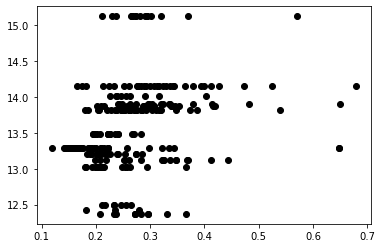

In [21]:
plt.plot(merged_data['d50'], merged_data['dc'], 'ko')

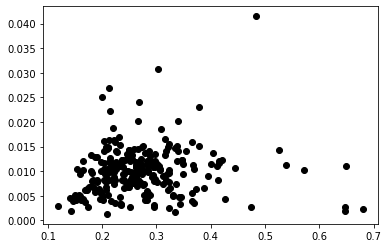

In [22]:
plt.plot(merged_data['d50'], merged_data['slope'], 'ko')

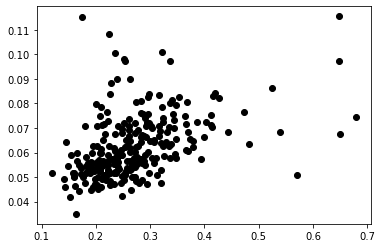

In [24]:
plt.plot(merged_data['d50'], merged_data['beach_slope_average'], 'ko')

In [25]:
aus30m = gpd.read_file('/media/marda/TWOTB1/USGS/SOFTWARE/Projects/NOPP/shoreline_data_Australia.geojson')
aus30m["geometry"] = aus30m["geometry"].to_crs(epsg=4326)

In [65]:
# aus30m.head()

In [35]:
bounds = dfEAus.bounds

In [43]:
# bounds.max()

In [44]:
# bounds.min()

In [38]:
# minx, miny, maxx, maxy,
b = box(149.528543, -37.736678, 153.637151, -25.854332)

In [39]:
polygon = Polygon(list(b.exterior.coords))

data_clipped = aus30m.clip(polygon)

In [66]:
data_clipped.head()

,OBJECTID,MasterKey,RandomSort,MEAN_SIG_WAVEHEIGHT,TIDAL_RANGE,CHLOROPHYLL,TURBIDITY,TEMP_MOISTURE,EMU_PHYSICAL,REGIONAL_SINUOSITY,...,sinuosity_label,slope_label,tidal_label,turbid_label,wave_label,CSU_Descriptor,CSU_ID,OUTFLOW_DENSITY_RESCALED,Shape_Length,geometry
2232,300767,300767,2.570800e+06,1.454914,1.764066,1.006219,0.1273,Warm Temperate Moist,Euhaline-Oxic-Warm to Very Warm,1.499636,...,straight,sloping,moderately tidal,moderately turbid,moderate wave energy,"sloping, straight, medium erodibility, warm te...",58029,0.002392,0.007980,"LINESTRING (151.50789 -33.23309, 151.50818 -33..."
2233,300775,300775,1.455922e+06,1.454914,1.764066,0.869298,0.1273,Warm Temperate Moist,Euhaline-Oxic-Warm to Very Warm,3.100705,...,sinuous,steeply sloping,moderately tidal,moderately turbid,moderate wave energy,"steeply sloping, sinuous, medium erodibility, ...",57768,0.002392,0.008080,"LINESTRING (151.53476 -33.23913, 151.53418 -33..."
2234,300778,300778,1.627740e+06,1.454914,1.764066,1.099951,0.1273,Warm Temperate Moist,Euhaline-Oxic-Warm to Very Warm,2.769717,...,sinuous,sloping,moderately tidal,moderately turbid,moderate wave energy,"sloping, sinuous, high erodibility, warm tempe...",6825,0.002392,0.008689,"LINESTRING (151.55549 -33.23596, 151.55522 -33..."
2235,300777,300777,4.220471e+05,1.454914,1.764066,0.977596,0.1273,Warm Temperate Moist,Euhaline-Oxic-Warm to Very Warm,3.100705,...,sinuous,sloping,moderately tidal,moderately turbid,moderate wave energy,"sloping, sinuous, medium erodibility, warm tem...",57690,0.002392,0.008474,"LINESTRING (151.54758 -33.23302, 151.54743 -33..."
2236,300826,300826,5.162680e+05,1.454914,1.764066,0.716648,0.1273,Warm Temperate Moist,Euhaline-Oxic-Warm to Very Warm,1.325699,...,straight,steeply sloping,moderately tidal,moderately turbid,moderate wave energy,"steeply sloping, straight, high erodibility, w...",7387,0.002392,0.008123,"LINESTRING (151.57863 -33.22931, 151.57828 -33..."


In [41]:
data_clipped.to_file('/media/marda/TWOTB1/USGS/SOFTWARE/Projects/NOPP/shoreline_data_East_Australia.geojson', driver="GeoJSON") 

/home/marda/anaconda3/envs/cgrasp/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [46]:
merged_data.keys()

Index(['latitude_left', 'longitude_left', 'd50', 'beach_slope_average', 'mstr',
       'hs_max', 'hs_mean', 'dir', 'tp', 'geometry', 'index_right',
       'longitude_right', 'latitude_right', 'dc', 'slope', 'error_code',
       'distances'],
      dtype='object')

In [47]:
merged_data = merged_data[['latitude_left', 'longitude_left', 'd50', 'beach_slope_average', 'mstr',
       'hs_max', 'hs_mean', 'dir', 'tp', 'geometry',  'dc', 'slope', 'error_code']].copy()

In [48]:
merged_all_data = gpd.sjoin_nearest(merged_data, data_clipped,distance_col="distances")

/tmp/ipykernel_41459/2409152181.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  merged_all_data = gpd.sjoin_nearest(merged_data, data_clipped,distance_col="distances")
/home/marda/anaconda3/envs/cgrasp/lib/python3.10/site-packages/geopandas/array.py:341: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [63]:
merged_all_data.head()

,latitude_left,longitude_left,d50,beach_slope_average,mstr,hs_max,hs_mean,dir,tp,geometry,...,sinuosity_label,slope_label,tidal_label,turbid_label,wave_label,CSU_Descriptor,CSU_ID,OUTFLOW_DENSITY_RESCALED,Shape_Length,distances
0,-25.854332,153.078347,0.29525,0.060145,2.068996,4.754424,1.565813,112.555036,8.719285,POINT (153.07835 -25.85433),...,straight,sloping,moderately tidal,moderately turbid,moderate wave energy,"sloping, straight, high erodibility, sub tropi...",12970,0.000712,0.008116,0.001421
1,-25.932753,153.134103,0.29525,0.082709,2.068996,4.754424,1.565813,112.555036,8.719285,POINT (153.13410 -25.93275),...,straight,steeply sloping,moderately tidal,moderately turbid,moderate wave energy,"steeply sloping, straight, high erodibility, s...",13462,0.000294,0.008677,0.008405
2,-26.008686,153.153149,0.27168,0.060027,2.058574,4.754424,1.565813,112.555036,8.719285,POINT (153.15315 -26.00869),...,straight,steeply sloping,moderately tidal,moderately turbid,moderate wave energy,"steeply sloping, straight, high erodibility, s...",13462,0.000294,0.008206,0.001390
3,-26.157750,153.097286,0.27168,0.054012,2.050147,4.754424,1.565813,112.555036,8.719285,POINT (153.09729 -26.15775),...,straight,vertical,moderately tidal,clear,moderate wave energy,"vertical, straight, high erodibility, sub trop...",13862,0.000022,0.008161,0.001038
4,-26.311676,153.068419,0.27168,0.049932,2.045488,4.754424,1.565813,112.555036,8.719285,POINT (153.06842 -26.31168),...,straight,steeply sloping,moderately tidal,moderately turbid,moderate wave energy,"steeply sloping, straight, high erodibility, s...",13462,0.000123,0.008081,0.006272


In [68]:
merged_all_data.keys()

Index(['latitude_left', 'longitude_left', 'd50', 'beach_slope_average', 'mstr',
       'hs_max', 'hs_mean', 'dir', 'tp', 'geometry', 'dc', 'slope',
       'error_code', 'index_right', 'OBJECTID', 'MasterKey', 'RandomSort',
       'MEAN_SIG_WAVEHEIGHT', 'TIDAL_RANGE', 'CHLOROPHYLL', 'TURBIDITY',
       'TEMP_MOISTURE', 'EMU_PHYSICAL', 'REGIONAL_SINUOSITY', 'GHM',
       'MAX_SLOPE', 'OUTFLOW_DENSITY', 'ERODIBILITY', 'Cluster', 'LENGTH_GEO',
       'chl_label', 'river_label', 'sinuosity_label', 'slope_label',
       'tidal_label', 'turbid_label', 'wave_label', 'CSU_Descriptor', 'CSU_ID',
       'OUTFLOW_DENSITY_RESCALED', 'Shape_Length', 'distances'],
      dtype='object')

In [78]:
merged_all_data['Cluster']

0      2
1      2
2      2
3      2
4      2
      ..
251    3
252    6
253    6
254    6
255    6
Name: Cluster, Length: 256, dtype: int64

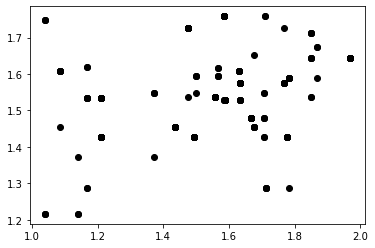

In [53]:
plt.plot(merged_all_data['hs_mean'], merged_all_data['MEAN_SIG_WAVEHEIGHT'], 'ko')

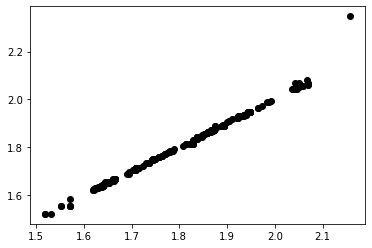

In [54]:
plt.plot(merged_all_data['mstr'], merged_all_data['TIDAL_RANGE'], 'ko')

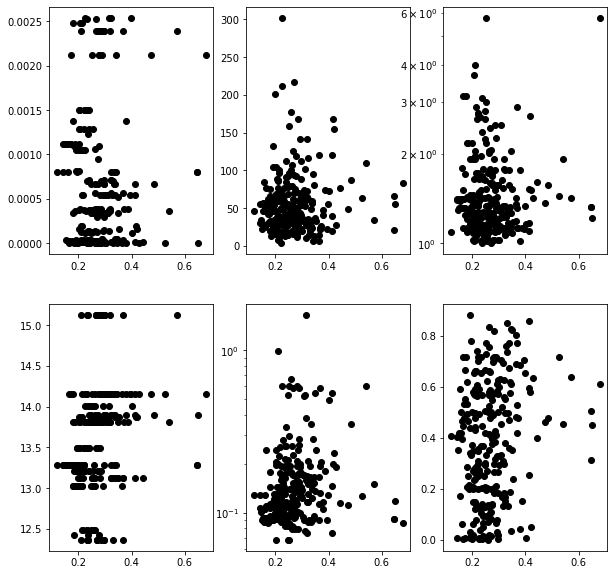

In [82]:
plt.figure(figsize=(10,10))

plt.subplot(231)
plt.plot(merged_all_data['d50'], merged_all_data['OUTFLOW_DENSITY_RESCALED'], 'ko')
plt.subplot(232)
plt.plot(merged_all_data['d50'], merged_all_data['MAX_SLOPE'], 'ko')
plt.subplot(233)
plt.semilogy(merged_all_data['d50'], merged_all_data['REGIONAL_SINUOSITY'], 'ko')
plt.subplot(234)
plt.plot(merged_all_data['d50'], merged_all_data['dc'], 'ko')
plt.subplot(235)
plt.semilogy(merged_all_data['d50'], merged_all_data['TURBIDITY'], 'ko')
plt.subplot(236)
plt.plot(merged_all_data['d50'], merged_all_data['GHM'], 'ko') #GlobalHumanModification

In [84]:
np.unique(merged_all_data['Cluster'])

array([2, 3, 6])

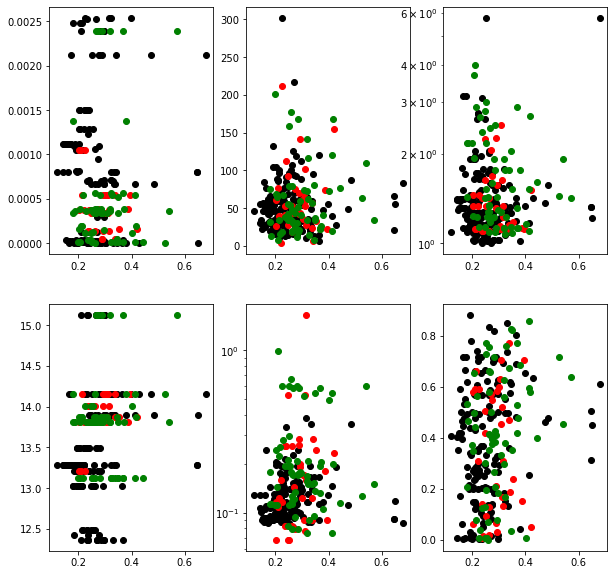

In [91]:
plt.figure(figsize=(10,10))

plt.subplot(231)
plt.plot(merged_all_data['d50'][merged_all_data['Cluster']==2], merged_all_data['OUTFLOW_DENSITY_RESCALED'][merged_all_data['Cluster']==2], 'ko')
plt.plot(merged_all_data['d50'][merged_all_data['Cluster']==3], merged_all_data['OUTFLOW_DENSITY_RESCALED'][merged_all_data['Cluster']==3], 'ro')
plt.plot(merged_all_data['d50'][merged_all_data['Cluster']==6], merged_all_data['OUTFLOW_DENSITY_RESCALED'][merged_all_data['Cluster']==6], 'go')


plt.subplot(232)
plt.plot(merged_all_data['d50'][merged_all_data['Cluster']==2], merged_all_data['MAX_SLOPE'][merged_all_data['Cluster']==2], 'ko')
plt.plot(merged_all_data['d50'][merged_all_data['Cluster']==3], merged_all_data['MAX_SLOPE'][merged_all_data['Cluster']==3], 'ro')
plt.plot(merged_all_data['d50'][merged_all_data['Cluster']==6], merged_all_data['MAX_SLOPE'][merged_all_data['Cluster']==6], 'go')

plt.subplot(233)
plt.semilogy(merged_all_data['d50'][merged_all_data['Cluster']==2], merged_all_data['REGIONAL_SINUOSITY'][merged_all_data['Cluster']==2], 'ko')
plt.semilogy(merged_all_data['d50'][merged_all_data['Cluster']==3], merged_all_data['REGIONAL_SINUOSITY'][merged_all_data['Cluster']==3], 'ro')
plt.semilogy(merged_all_data['d50'][merged_all_data['Cluster']==6], merged_all_data['REGIONAL_SINUOSITY'][merged_all_data['Cluster']==6], 'go')

plt.subplot(234)
plt.plot(merged_all_data['d50'][merged_all_data['Cluster']==2], merged_all_data['dc'][merged_all_data['Cluster']==2], 'ko')
plt.plot(merged_all_data['d50'][merged_all_data['Cluster']==3], merged_all_data['dc'][merged_all_data['Cluster']==3], 'ro')
plt.plot(merged_all_data['d50'][merged_all_data['Cluster']==6], merged_all_data['dc'][merged_all_data['Cluster']==6], 'go')

plt.subplot(235)
plt.semilogy(merged_all_data['d50'][merged_all_data['Cluster']==2], merged_all_data['TURBIDITY'][merged_all_data['Cluster']==2], 'ko')
plt.semilogy(merged_all_data['d50'][merged_all_data['Cluster']==3], merged_all_data['TURBIDITY'][merged_all_data['Cluster']==3], 'ro')
plt.semilogy(merged_all_data['d50'][merged_all_data['Cluster']==6], merged_all_data['TURBIDITY'][merged_all_data['Cluster']==6], 'go')

plt.subplot(236)
plt.plot(merged_all_data['d50'][merged_all_data['Cluster']==2], merged_all_data['GHM'][merged_all_data['Cluster']==2], 'ko') 
plt.plot(merged_all_data['d50'][merged_all_data['Cluster']==3], merged_all_data['GHM'][merged_all_data['Cluster']==3], 'ro') 
plt.plot(merged_all_data['d50'][merged_all_data['Cluster']==6], merged_all_data['GHM'][merged_all_data['Cluster']==6], 'go') 
